In [66]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Benchmark Speed Comparison: Training TF-GNN and PyG's GCN Models on Citeseer Node Classification Dataset

Speed framework comparisons between TF-GNN and PyG serve the purpose of assessing the computational efficiency and performance of both ML frameworks. BY benchmarking TF-GNN against PyG, the TF-GNN community gains insight into areas of enhancement for model architectures and training strategies.
Leveraging the pyg_adapter utility, benchmarking TF-GNN against PyG will involve comparing the speed performance of training TF-GNN and PyG’s GCN model architectures on PyG's Citeseer dataset.


The CiteSeer dataset is a homogeneous single graph dataset from the Planetoid collection. The dataset consists of 3327 documents that comprise node features that contain sparse bag-of-words feature vectors for each document. The node features are essentially a binary 0/1-valued word vector indicating whether a corresponding word from the dataset's word dictionary is present in the document. The dictionary consists of 3703 unique words. Edges are represented as citation links between documents, and each document is classified into one of six classes.

For a fair comparison between TF-GNN and PyG, both TF-GNN and PyG GCN models are strcutured and trained in similar according to the model layout and hyperparameters specified in the “SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS" paper (with dropout rate adjusted to 0.2 and the preprocessing row normalization layer for node features excluded).

Specifically the following model layout and hyper parameters are used:

For both frameworks we train a two-layer GCN with the following hyperparameters:
<ul>
<li>Input Layer: 3703 units</li>
<li>Hidden Layer 1: 16 units</li>
<li>Output Layer: 6 units</li>

<li>Epochs: 60 </li>

<li>Dropout: 0.2 </li>

<li>Weight_decay: 5e-4 </i>

<li>Optimizer: Adam with a learning rate of 0.01 </li>

<li>Weight Initialization: Glorot </li>
<ul>


# Imports

Before Python can import tensorflow_gnn and torch_geometric, the PIP package needs to install and download them.

In [67]:
#installations
from IPython.display import clear_output
!pip install tensorflow_gnn
!pip install torch_geometric

clear_output()

In [68]:
#imports
import collections
from dataclasses import dataclass
from typing import List, Mapping, Tuple, Union, Callable, Optional

#tfgnn imports
from tensorflow_gnn.models.gcn import gcn_conv
import tensorflow as tf
import tensorflow_gnn as tfgnn
import keras

#pyg imports
from torch_geometric.datasets import *
from torch_geometric import data as tg_data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

#other
import numpy as np
import time
import matplotlib.pyplot as plt


source code for pyg_adapter provided below

In [69]:
# @title
@dataclass
class GraphInfo:
  context_features: Mapping[str, List[np.ndarray]]
  node_features: Mapping[str, Mapping[str, List[np.ndarray]]]
  edge_features: Mapping[
      Union[Tuple[str, str, str], str], Mapping[str, List[np.ndarray]]
  ]
  graph_data: Mapping[
      Union[str, Tuple[str, str, str]], Mapping[str, List[np.ndarray]]
  ]


def build_graph_tensor_pyg(
    dataset: tg_data.InMemoryDataset,
) -> tfgnn.GraphTensor:
  """Returns a graph tensor.

  Args:
    dataset: PyG dataset to be converted into graph tensor.

  Returns:
    A graph tensor.

  Raises:
    ValueError: if input dataset is not a PyG in memory dataset.
  """
  if not isinstance(dataset, tg_data.InMemoryDataset):
    raise ValueError(
        f'dataset: {type(dataset)} is not a PyG in memory dataset.'
    )

  if isinstance(dataset[0], tg_data.data.Data):
    graph_info = _extract_features_homogenous(dataset)
  elif isinstance(dataset[0], tg_data.hetero_data.HeteroData):
    graph_info = _extract_features_heterogeneous(dataset)
  else:
    raise ValueError(f'dataset: {type(dataset)} is not currently supported.')

  graph = _build_graph_tensor(graph_info)
  return graph


def _extract_features_homogenous(dataset: tg_data.InMemoryDataset) -> GraphInfo:
  """Extracts graph structural data and features from homogenous dataset.

  Args:
    dataset: A homogenous PyG dataset.

  Returns:
    An instance of GraphInfo.

  Raises:
    ValueError: if input dataset is not homogenous.
  """

  if not isinstance(dataset[0], tg_data.data.Data):
    raise ValueError(f'dataset: {type(dataset)} is not a homogenous dataset.')

  node_features = {tfgnn.NODES: collections.defaultdict(list)}
  edge_features = {tfgnn.EDGES: collections.defaultdict(list)}
  context_features = collections.defaultdict(list)
  graph_data = {
      tfgnn.NODES: collections.defaultdict(list),
      tfgnn.EDGES: collections.defaultdict(list),
  }

  for graph in dataset:
    graph_map = graph.to_dict()
    list_of_fields = graph_map.keys() - {'num_nodes'}
    graph_data[tfgnn.NODES]['list_num_nodes'].append([graph.num_nodes])
    graph_data[tfgnn.EDGES]['list_num_edges'].append([graph.num_edges])

    for field in list_of_fields:
      if graph.is_node_attr(field):
        node_features[tfgnn.NODES][field].append(graph_map[field].numpy())

      elif graph.is_edge_attr(field):
        if field == 'edge_index':
          graph_data[tfgnn.EDGES]['source_edge'].append(
              graph_map[field].numpy()[0]
          )
          graph_data[tfgnn.EDGES]['target_edge'].append(
              graph_map[field].numpy()[1]
          )
        else:
          edge_features[tfgnn.EDGES][field].append(graph_map[field].numpy())

      elif len(graph_map[field]) == 1:
        context_features[field].append(graph_map[field].numpy())
      else:
        temp = graph_map[field].numpy()
        context_features[field].append(np.expand_dims(temp, axis=0))

  graph_info = GraphInfo(
      context_features, node_features, edge_features, graph_data
  )
  return graph_info


def _extract_features_heterogeneous(
    dataset: tg_data.InMemoryDataset,
) -> GraphInfo:
  """Extracts graph structural data and features from heterogeneous dataset.

  Args:
    dataset: A heterogeneous PyG dataset.

  Returns:
    An instance of GraphInfo.

  Raises:
    ValueError: if input dataset is not heterogeneous.
  """

  if not isinstance(dataset[0], tg_data.hetero_data.HeteroData):
    raise ValueError(
        f'dataset: {type(dataset)} is not a heterogeneous dataset.'
    )

  node_types = dataset[0].node_types
  edge_types = dataset[0].edge_types

  node_features = {}
  edge_features = {}
  context_features = collections.defaultdict(list)
  graph_data = collections.defaultdict(lambda: collections.defaultdict(list))

  for graph in dataset:
    graph_map = graph.to_dict()

    for node_type in node_types:
      if node_type not in node_features:
        node_features[node_type] = collections.defaultdict(list)
      node_data = graph_map.pop(node_type)

      if 'num_nodes' in node_data:
        graph_data[node_type]['list_num_nodes'].append(
            [node_data.pop('num_nodes')]
        )
      else:
        # appending size information only once for a given node_type.
        for node_feature in node_data.keys():
          graph_data[node_type]['list_num_nodes'].append(
              [len(node_data[node_feature])]
          )
          break
      for node_feature in node_data.keys():
        node_features[node_type][node_feature].append(
            node_data[node_feature].numpy()
        )

    for edge_type in edge_types:
      if edge_type not in edge_features:
        edge_features[edge_type] = collections.defaultdict(list)
      edge_data = graph_map.pop(edge_type)
      for edge_piece in edge_data.keys():
        if edge_piece == 'edge_index':
          graph_data[edge_type]['source_edge'].append(
              edge_data['edge_index'][0].numpy()
          )
          graph_data[edge_type]['target_edge'].append(
              edge_data['edge_index'][1].numpy()
          )
          graph_data[edge_type]['list_num_edges'].append(
              [len(edge_data['edge_index'][0].numpy())]
          )
        else:
          edge_features[edge_type][edge_piece].append(
              edge_data[edge_piece].numpy()
          )

    for context_feature in graph_map.keys():
      if len(graph_map[context_feature]) == 1:
        context_features[context_feature].append(
            graph_map[context_feature].numpy()
        )
      else:
        temp = graph_map[context_feature].numpy()
        context_features[context_feature].append(np.expand_dims(temp, axis=0))

  graph_info = GraphInfo(
      context_features, node_features, edge_features, graph_data
  )
  return graph_info


def _build_graph_tensor(graph_info: GraphInfo) -> tfgnn.GraphTensor:
  """Returns a graph tensor.

  Args:
    graph_info: a GraphInfo instance comprising node/context/edge structure and
      feature related data.

  Returns:
    A graph tensor
  """
  node_sets = _build_node_sets(graph_info)
  edge_sets = _build_edge_sets(graph_info)
  context_set = {}
  for _, context_feature in graph_info.context_features.items():
    if len(context_feature) == 1:
      context_set = {
          k: tf.constant(v[0]) for k, v in graph_info.context_features.items()
      }
    else:
      context_set = {
          k: tf.constant(v) for k, v in graph_info.context_features.items()
      }
    break
  graph_context_set = tfgnn.Context.from_fields(features=context_set)
  graph = tfgnn.GraphTensor.from_pieces(graph_context_set, node_sets, edge_sets)
  return graph


def _build_node_sets(graph_info: GraphInfo) -> Mapping[str, tfgnn.NodeSet]:
  """builds node sets.

  Args:
    graph_info: a GraphInfo instance comprising node/context/edge structure and
      feature related data.

  Returns:
    node sets
  """
  node_data = {}
  node_sets = {}
  for node_type in graph_info.node_features.keys():
    sizes = graph_info.graph_data[node_type]['list_num_nodes']
    if len(sizes) == 1:
      sizes = tf.constant(graph_info.graph_data[node_type]['list_num_nodes'][0])
      node_data[node_type] = {
          k: tf.constant(v[0])
          for k, v in graph_info.node_features[node_type].items()
      }
    else:
      sizes = tf.constant(graph_info.graph_data[node_type]['list_num_nodes'])
      node_data[node_type] = {
          k: tf.ragged.constant(v, ragged_rank=1)
          for k, v in graph_info.node_features[node_type].items()
      }
    node_sets[node_type] = tfgnn.NodeSet.from_fields(
        sizes=sizes, features=node_data[node_type]
    )
  return node_sets


def _build_edge_sets(graph_info: GraphInfo) -> Mapping[str, tfgnn.EdgeSet]:
  """builds edge sets.

  Args:
   graph_info: a GraphInfo isntance comprising node/context/edge structure and
     feature related data.

  Returns:
    edge sets
  """
  edge_data = {}
  edge_sets = {}
  for edge_type in graph_info.edge_features.keys():
    # PyG represents edge types in heterogeneous datasets as a tuple of strings
    # of length 3, with the following format:(source_node, relationship_name,
    # target_node). In converting into graph tensor, the tuple is concatenated
    # into a string.
    if isinstance(edge_type, str):
      edge_name = edge_type
      source = tfgnn.NODES
      target = tfgnn.NODES
    else:
      source, edge_name, target = edge_type
      # updating `edge_name` to `f'{source}-{edge_name}-{target}'` to ensure
      # `edge_name` is unique.
      edge_name = f'{source}-{edge_name}-{target}'
    sizes = graph_info.graph_data[edge_type]['list_num_edges']
    if len(sizes) == 1:
      sizes = tf.constant(graph_info.graph_data[edge_type]['list_num_edges'][0])
      edge_data[edge_name] = {
          k: tf.constant(v[0])
          for k, v in graph_info.edge_features[edge_type].items()
      }
      adjacency_source = tf.constant(
          graph_info.graph_data[edge_type]['source_edge'][0]
      )
      adjacency_target = tf.constant(
          graph_info.graph_data[edge_type]['target_edge'][0]
      )
    else:
      sizes = tf.constant(graph_info.graph_data[edge_type]['list_num_edges'])
      adjacency_source = tf.ragged.constant(
          graph_info.graph_data[edge_type]['source_edge'],
          ragged_rank=1,
      )
      adjacency_target = tf.ragged.constant(
          graph_info.graph_data[edge_type]['target_edge'],
          ragged_rank=1,
      )
      edge_data[edge_name] = {
          k: tf.ragged.constant(v, ragged_rank=1)
          for k, v in graph_info.edge_features[edge_type].items()
      }
    edge_sets[edge_name] = tfgnn.EdgeSet.from_fields(
        sizes=sizes,
        adjacency=tfgnn.Adjacency.from_indices(
            source=(
                source,
                adjacency_source,
            ),
            target=(
                target,
                adjacency_target,
            ),
        ),
        features=edge_data[edge_name],
    )
  return edge_sets

# Download the PyG Citeseer dataset

In [70]:
dataset_CITESEER = Planetoid(root='/tmp/CITESEER', name='Citeseer')
clear_output()

# TFGNN GCN MODEL

In [71]:
# Converting PyG Citeseer dataset into tfgnn graph tensor
graph_citeseer = build_graph_tensor_pyg(dataset_CITESEER)

In [72]:
# Looking at node, edge, and context features in Citeseer graph tensor
print(graph_citeseer.node_sets)
print(graph_citeseer.edge_sets)
print(graph_citeseer.context)

{'nodes': NodeSet(features={'val_mask': <tf.Tensor: shape=(3327,), dtype=tf.bool>, 'x': <tf.Tensor: shape=(3327, 3703), dtype=tf.float32>, 'train_mask': <tf.Tensor: shape=(3327,), dtype=tf.bool>, 'y': <tf.Tensor: shape=(3327,), dtype=tf.int64>, 'test_mask': <tf.Tensor: shape=(3327,), dtype=tf.bool>}, sizes=[3327])}
{'edges': EdgeSet(features={}, sizes=[9104], adjacency=Adjacency(source=('nodes', <tf.Tensor: shape=(9104,), dtype=tf.int64>), target=('nodes', <tf.Tensor: shape=(9104,), dtype=tf.int64>)))}
Context(features={}, sizes=[1], shape=(), indices_dtype=tf.int32)


In [73]:
# Helper function to pop and return labels and train/valid/test masks from citeseer graph_tensor
def pop_labels_and_generate_mask(mask:str, graph= build_graph_tensor_pyg(dataset_CITESEER)):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['nodes'].get_features_dict()

    labels = node_features.pop('y')
    train_mask = node_features.pop('train_mask')
    validation_mask = node_features.pop('val_mask')
    test_mask = node_features.pop('test_mask')

    new_graph = graph.replace_features(node_sets={'nodes':node_features})
    sample_weights = np.zeros(len(labels))
    if mask == 'train':
      sample_weights[train_mask] = 1
      return new_graph, labels, sample_weights
    elif mask == 'validation':
      sample_weights[validation_mask] = 1
      return new_graph, labels, sample_weights
    elif mask == 'test':
      sample_weights[test_mask] = 1
      return new_graph, labels, sample_weights
    else:
      raise ValueError("mask should be an element of ['train', 'validation', 'test']")

In [74]:
# Creating tensorflow train, validation, and test datasets
def create_tf_ds():
    train_dataset = tf.data.Dataset.from_tensors((pop_labels_and_generate_mask('train')))
    validation_dataset =  tf.data.Dataset.from_tensors((pop_labels_and_generate_mask('validation')))
    test_dataset =  tf.data.Dataset.from_tensors((pop_labels_and_generate_mask('test')))
    return train_dataset, validation_dataset, test_dataset
train_ds, validation_ds, test_ds = create_tf_ds()

## Build the TF-GNN GCN model and training loop

In [75]:
# defining model inputs and dropout layer
def set_initial_node_state(node_set, node_set_name):
  return node_set['x']

def dropout(node_set, node_set_name):
  return tf.keras.layers.Dropout(0.2)(node_set[tfgnn.HIDDEN_STATE])

In [76]:
# building tfgnn gcn model
def initialize_model(strategy, train_ds):
  with strategy.scope():
    graph_spec = train_ds.element_spec[0]
    input_graph = tf.keras.layers.Input(type_spec=graph_spec)
    graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=set_initial_node_state)(input_graph)

    #graph updates
    graph_updates = 2
    units = [16, 6]
    activations = ['relu', None]
    for i in range(graph_updates):
      graph = gcn_conv.GCNHomGraphUpdate(units=units[i], receiver_tag=tfgnn.TARGET, activation = activations[i], name=f'gcn_s_{i}',  kernel_initializer = 'glorot_uniform',kernel_regularizer=tf.keras.regularizers.l2(5e-4))(graph)
      graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=dropout)(graph)

    logits = graph.node_sets["nodes"][tfgnn.HIDDEN_STATE]
    node_model = tf.keras.Model(input_graph, logits)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    node_model.compile(
    optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction = tf.keras.losses.Reduction.SUM),
    weighted_metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
    return node_model


In [77]:
# building the tfgnn training loop
def train_gcn_model_tfgnn(*, runtime = 'gpu', runs = 10, threshold = 10, epochs = 50, train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(), val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()):
  train_times = []
  if runtime == 'gpu':
    device = '/gpu:0'
  else:
    device = '/cpu:0'
  with tf.device(device):
    for run in range(runs):
      train_time = []
      strategy = tf.distribute.MirroredStrategy()
      node_model = initialize_model(strategy, train_ds)
      with strategy.scope():
        dist_dataset = strategy.experimental_distribute_dataset(train_ds)
        example, labels, train_weights = next(iter(dist_dataset))
        _, _, validation_weights = next(iter(validation_ds))

        @tf.function
        def distribute_train_step():
          def replica_fn():
            with tf.GradientTape() as tape:
              logits = node_model(example, training=True)
              loss = node_model.loss(labels, logits, train_weights)
            grads = tape.gradient(loss, node_model.trainable_weights)
            node_model.optimizer.apply_gradients(zip(grads, node_model.trainable_weights))
            return loss, logits
          return strategy.run(replica_fn)

        for epoch in range(epochs+threshold):

          #training
          start_time = time.perf_counter()
          loss, logits = distribute_train_step()
          duration = time.perf_counter()-start_time

          #calculating acc metrics
          train_acc_metric.update_state(labels, logits, train_weights)
          acc_train = train_acc_metric.result()
          val_acc_metric.update_state(labels, logits, validation_weights)
          acc_val = val_acc_metric.result()
          train_acc_metric.reset_states()
          val_acc_metric.reset_states()

          train_time.append(duration)
          print(f'Epoch:{epoch+1}\n-train loss: {loss}\n-train accuracy: {acc_train}\n-valid accuracy: {acc_val}\n-train duration: {duration}')
        train_times.append(train_time)
        _, acc_test = node_model.evaluate(test_ds, verbose = 0)
        print(f'Test accuracy: {acc_test}')
        print("Total time to train round {} of {} epochs is: {}s".format(run+1, epochs, round(sum(train_times[-1][threshold:]), 2)))
  avg_time = sum([sum(train_time[threshold:]) for train_time in train_times])/runs
  print('Avg training time for {} rounds of {} epochs: {}s'.format(runs, epochs, round(avg_time, 2)) )
  return train_times


# PYG GCN MODEL

In [78]:
# building PyG gcn model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset_CITESEER.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset_CITESEER.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0.2)
        x = self.conv2(x, edge_index)
        x = F.dropout(x, training=self.training, p=0.2)

        return F.log_softmax(x, dim=1)

In [79]:
# building the pyg training loop
def train_gcn_model_pyg(*, runtime = 'gpu', runs = 10, threshold = 10, epochs = 50):
  train_times = []
  for run in range(runs):
    if runtime == 'gpu':
      device = torch.device('cuda')
    else:
      device = torch.device('cpu')
    model = Net().to(device)
    data = dataset_CITESEER[0].to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    train_time = []
    for epoch in range(threshold+epochs):

      #training
      start_time=time.perf_counter()
      model.train()
      optimizer.zero_grad()
      out = model(data)
      loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      torch.cuda.synchronize()
      duration = time.perf_counter()-start_time
      train_time.append(duration)

      #calculating acc metrics
      _, pred = out.max(dim=1)
      correct_train = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
      acc_train = correct_train / int(data.train_mask.sum())
      correct_valid = int(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
      acc_valid = correct_valid / int(data.val_mask.sum())

      print(f'Epoch:{epoch+1}\n-train loss: {loss}\n-train accuracy: {acc_train}\n-valid accuracy: {acc_valid}\n-train duration: {duration}')
    train_times.append(train_time)

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    print('Test accuracy: {:.4f}'.format(acc))

    print("Total time to train round {} of {} epochs is: {}s".format(run+1, epochs, round(sum(train_times[-1][threshold:]), 2)))
  avg_time = sum([sum(train_time[threshold:]) for train_time in train_times])/runs
  print('Avg training time for {} rounds of {} epochs: {}s'.format(runs, epochs, round(avg_time, 2)))
  return train_times

# Speed Benchmarking

In [80]:
# constants used in benchmark training
runs = 10
threshold = 10
epochs = 50

In [81]:
tfgnn_gpu_train_times = train_gcn_model_tfgnn(runtime='gpu', runs=runs, threshold=threshold, epochs=epochs)

Epoch:1
-train loss: 217.54705810546875
-train accuracy: 0.13333334028720856
-valid accuracy: 0.18799999356269836
-train duration: 1.575971381999807
Epoch:2
-train loss: 198.96881103515625
-train accuracy: 0.5249999761581421
-valid accuracy: 0.30399999022483826
-train duration: 0.006123391000073752
Epoch:3
-train loss: 181.777099609375
-train accuracy: 0.5
-valid accuracy: 0.3659999966621399
-train duration: 0.017830497000431933
Epoch:4
-train loss: 153.3623046875
-train accuracy: 0.6499999761581421
-valid accuracy: 0.38199999928474426
-train duration: 0.0023721819998172577
Epoch:5
-train loss: 139.265380859375
-train accuracy: 0.7583333253860474
-valid accuracy: 0.3799999952316284
-train duration: 0.0019963450004070182
Epoch:6
-train loss: 122.0848159790039
-train accuracy: 0.75
-valid accuracy: 0.4399999976158142
-train duration: 0.002023920000283397
Epoch:7
-train loss: 115.04571533203125
-train accuracy: 0.75
-valid accuracy: 0.4560000002384186
-train duration: 0.002052186999208061

In [82]:
pyg_gpu_train_times = train_gcn_model_pyg(runtime = 'gpu',  runs=runs, threshold=threshold, epochs=epochs)

Epoch:1
-train loss: 1.787692666053772
-train accuracy: 0.16666666666666666
-valid accuracy: 0.116
-train duration: 0.004299430000173743
Epoch:2
-train loss: 1.5966074466705322
-train accuracy: 0.6416666666666667
-valid accuracy: 0.35
-train duration: 0.003986337999776879
Epoch:3
-train loss: 1.359682321548462
-train accuracy: 0.6916666666666667
-valid accuracy: 0.404
-train duration: 0.0041235790004066075
Epoch:4
-train loss: 1.1712781190872192
-train accuracy: 0.675
-valid accuracy: 0.4
-train duration: 0.00364957100009633
Epoch:5
-train loss: 0.9178755283355713
-train accuracy: 0.7666666666666667
-valid accuracy: 0.438
-train duration: 0.0036336610000944347
Epoch:6
-train loss: 0.8516823649406433
-train accuracy: 0.7916666666666666
-valid accuracy: 0.476
-train duration: 0.0036559479995048605
Epoch:7
-train loss: 0.7038094401359558
-train accuracy: 0.85
-valid accuracy: 0.492
-train duration: 0.0036849840007562307
Epoch:8
-train loss: 0.6130210757255554
-train accuracy: 0.8166666666

In [82]:
pyg_gpu_train_times = train_gcn_model_pyg(runtime = 'gpu',  runs=runs, threshold=threshold, epochs=epochs)

Epoch:1
-train loss: 1.787692666053772
-train accuracy: 0.16666666666666666
-valid accuracy: 0.116
-train duration: 0.004299430000173743
Epoch:2
-train loss: 1.5966074466705322
-train accuracy: 0.6416666666666667
-valid accuracy: 0.35
-train duration: 0.003986337999776879
Epoch:3
-train loss: 1.359682321548462
-train accuracy: 0.6916666666666667
-valid accuracy: 0.404
-train duration: 0.0041235790004066075
Epoch:4
-train loss: 1.1712781190872192
-train accuracy: 0.675
-valid accuracy: 0.4
-train duration: 0.00364957100009633
Epoch:5
-train loss: 0.9178755283355713
-train accuracy: 0.7666666666666667
-valid accuracy: 0.438
-train duration: 0.0036336610000944347
Epoch:6
-train loss: 0.8516823649406433
-train accuracy: 0.7916666666666666
-valid accuracy: 0.476
-train duration: 0.0036559479995048605
Epoch:7
-train loss: 0.7038094401359558
-train accuracy: 0.85
-valid accuracy: 0.492
-train duration: 0.0036849840007562307
Epoch:8
-train loss: 0.6130210757255554
-train accuracy: 0.8166666666

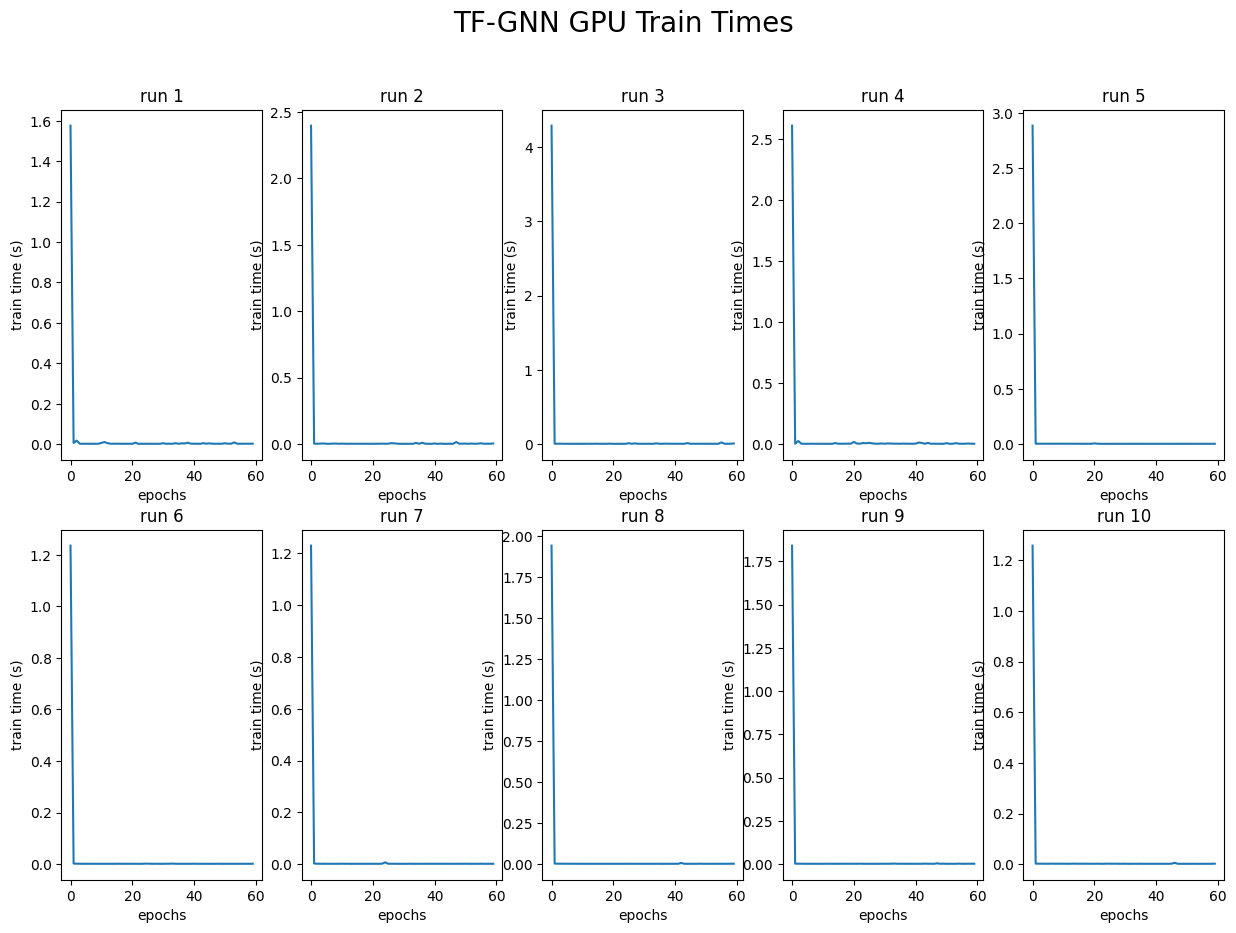

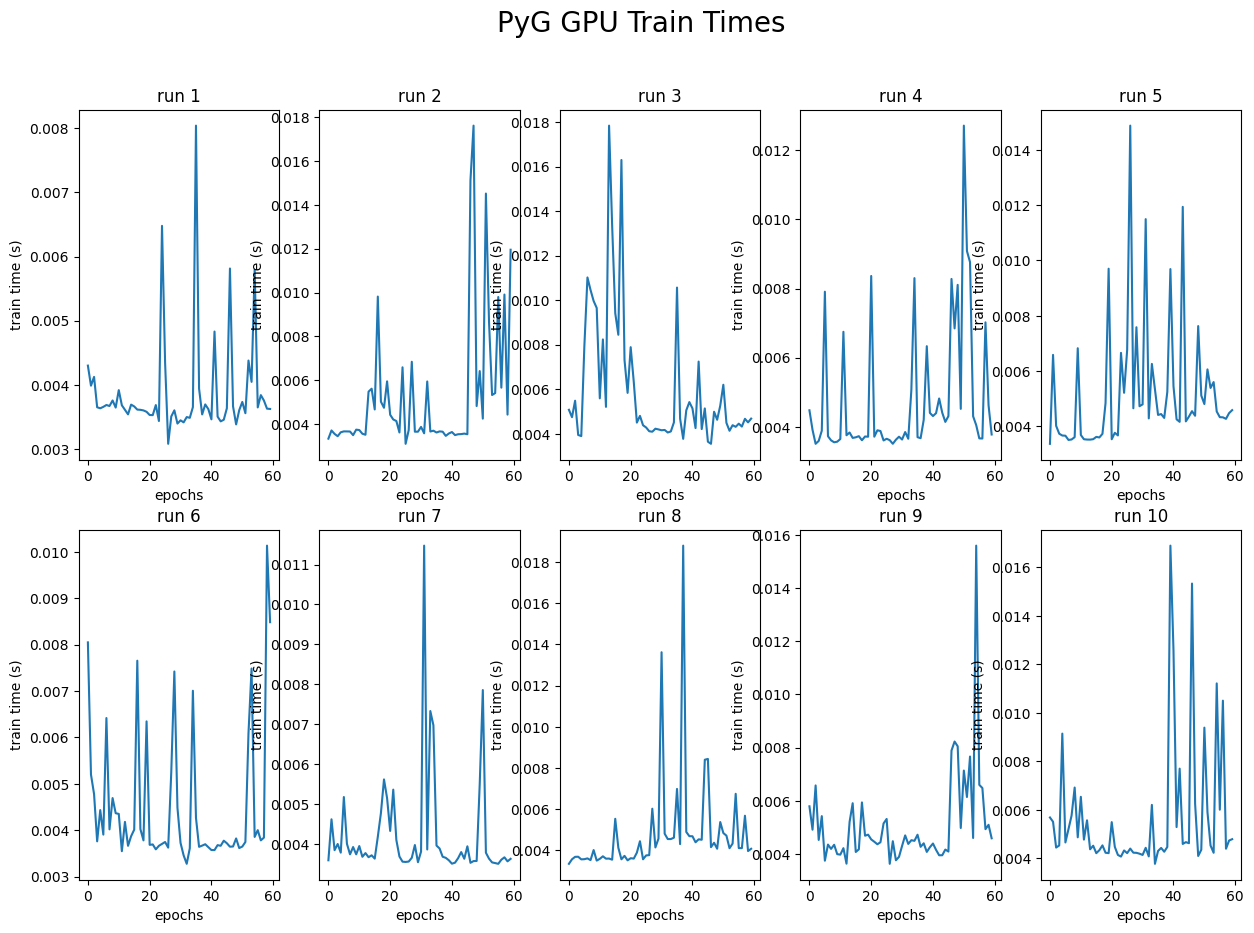

In [83]:
rows = 2
cols = 5
f, axes = plt.subplots(rows, cols, figsize=(15, 10))
for row in range(rows):
  for col in range(cols):
    axes[row, col].plot(tfgnn_gpu_train_times[(row*cols)+col])
    axes[row, col].set_title('run '+str(((row*cols)+col)+1))
    axes[row, col].set_xlabel('epochs')
    axes[row, col].set_ylabel('train time (s)')

f.suptitle('TF-GNN GPU Train Times', fontsize=20)
plt.show()

f, axes = plt.subplots(rows, cols, figsize=(15, 10))
for row in range(rows):
  for col in range(cols):
    axes[row, col].plot(pyg_gpu_train_times[(row*cols)+col])
    axes[row, col].set_title('run '+str(((row*cols)+col)+1))
    axes[row, col].set_xlabel('epochs')
    axes[row, col].set_ylabel('train time (s)')

f.suptitle('PyG GPU Train Times', fontsize=20)
plt.show()

In [84]:
tfgnn_cpu_train_times = train_gcn_model_tfgnn(runtime='cpu', runs=runs, threshold=threshold, epochs=epochs)

Epoch:1
-train loss: 217.7110137939453
-train accuracy: 0.14166666567325592
-valid accuracy: 0.2240000069141388
-train duration: 3.0038807689998066
Epoch:2
-train loss: 200.28250122070312
-train accuracy: 0.49166667461395264
-valid accuracy: 0.38199999928474426
-train duration: 0.0077225039995028055
Epoch:3
-train loss: 183.42047119140625
-train accuracy: 0.46666666865348816
-valid accuracy: 0.4000000059604645
-train duration: 0.011967093999373901
Epoch:4
-train loss: 158.39010620117188
-train accuracy: 0.550000011920929
-valid accuracy: 0.38600000739097595
-train duration: 0.0075591849999909755
Epoch:5
-train loss: 142.7369842529297
-train accuracy: 0.6083333492279053
-valid accuracy: 0.3700000047683716
-train duration: 0.0075066230001539225
Epoch:6
-train loss: 136.34707641601562
-train accuracy: 0.5416666865348816
-valid accuracy: 0.3779999911785126
-train duration: 0.011179842999808898
Epoch:7
-train loss: 109.93599700927734
-train accuracy: 0.7166666388511658
-valid accuracy: 0.39

In [85]:
pyg_cpu_train_times = train_gcn_model_pyg(runtime = 'cpu',  runs=runs, threshold=threshold, epochs=epochs)

Epoch:1
-train loss: 1.7973741292953491
-train accuracy: 0.15
-valid accuracy: 0.188
-train duration: 0.037715063000177906
Epoch:2
-train loss: 1.6244758367538452
-train accuracy: 0.6
-valid accuracy: 0.32
-train duration: 0.037585888999274175
Epoch:3
-train loss: 1.4143469333648682
-train accuracy: 0.6416666666666667
-valid accuracy: 0.358
-train duration: 0.0331648290002704
Epoch:4
-train loss: 1.2505648136138916
-train accuracy: 0.6166666666666667
-valid accuracy: 0.33
-train duration: 0.03418179799973586
Epoch:5
-train loss: 1.038831114768982
-train accuracy: 0.725
-valid accuracy: 0.432
-train duration: 0.04347078800037707
Epoch:6
-train loss: 0.9047868251800537
-train accuracy: 0.75
-valid accuracy: 0.458
-train duration: 0.047233295000296494
Epoch:7
-train loss: 0.8766405582427979
-train accuracy: 0.7333333333333333
-valid accuracy: 0.46
-train duration: 0.04029001500020968
Epoch:8
-train loss: 0.7376531958580017
-train accuracy: 0.7833333333333333
-valid accuracy: 0.532
-train 

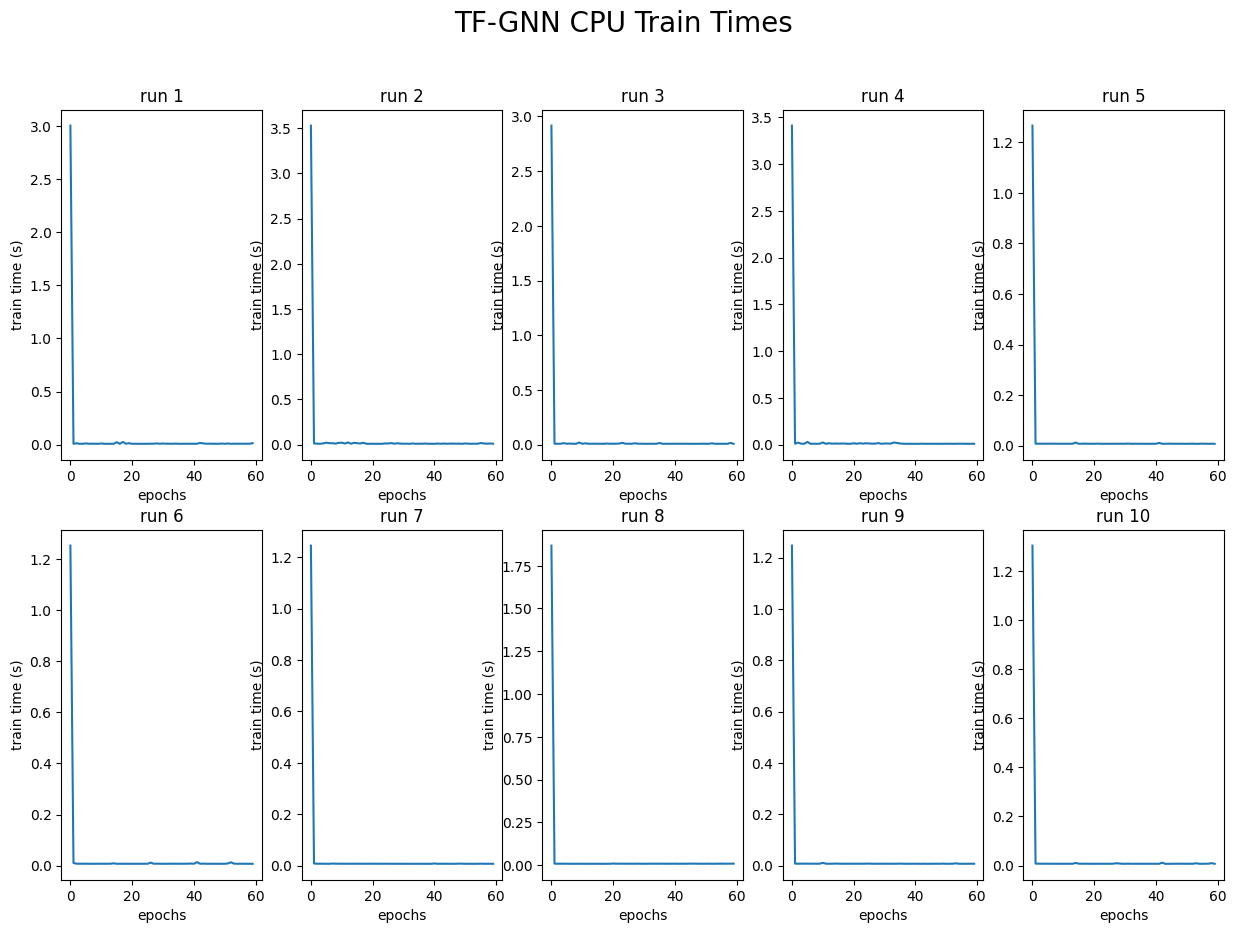

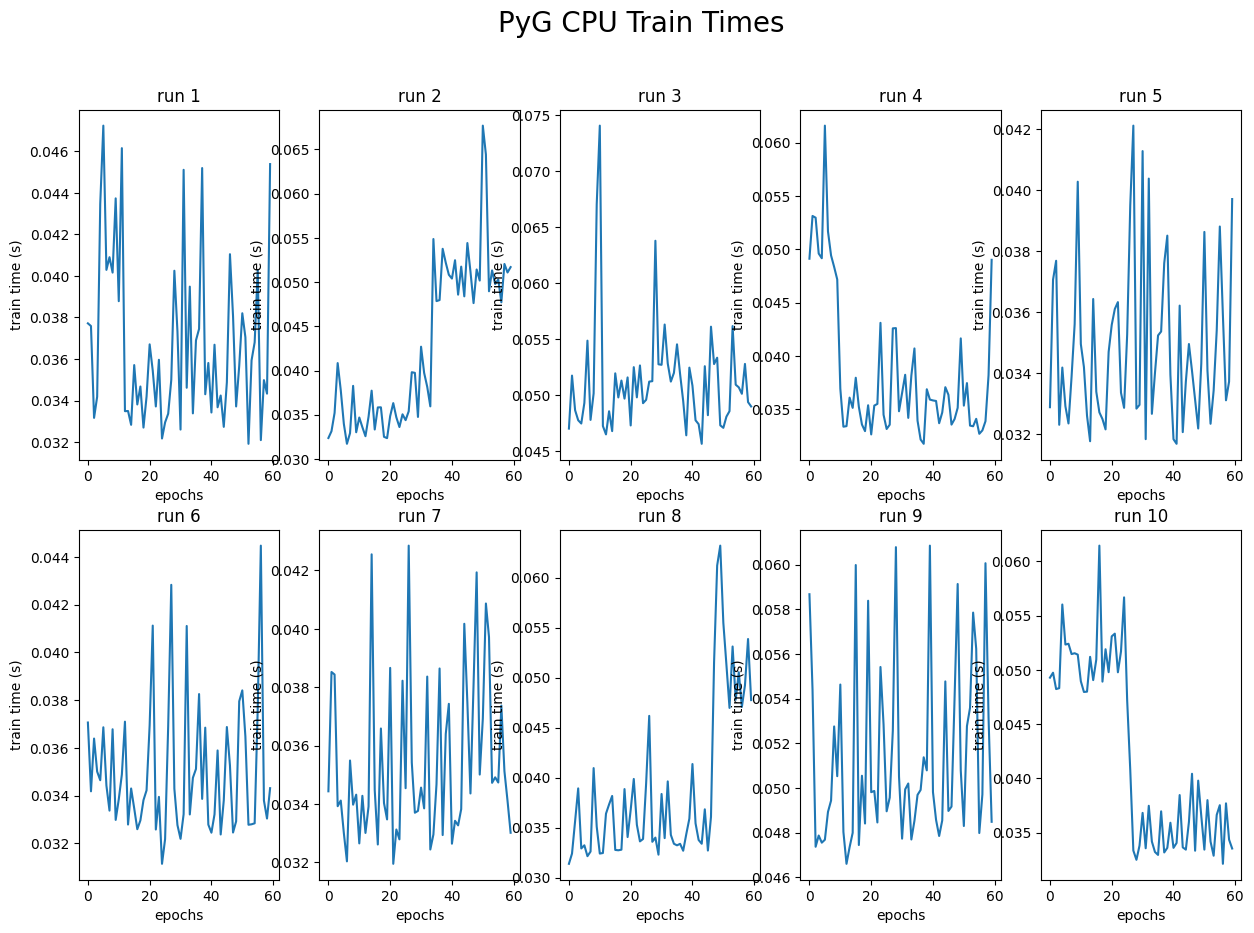

In [86]:
rows = 2
cols = 5
f, axes = plt.subplots(rows, cols, figsize=(15, 10))
for row in range(rows):
  for col in range(cols):
    axes[row, col].plot(tfgnn_cpu_train_times[(row*cols)+col])
    axes[row, col].set_title('run '+str(((row*cols)+col)+1))
    axes[row, col].set_xlabel('epochs')
    axes[row, col].set_ylabel('train time (s)')

f.suptitle('TF-GNN CPU Train Times', fontsize=20)
plt.show()

f, axes = plt.subplots(rows, cols, figsize=(15, 10))
for row in range(rows):
  for col in range(cols):
    axes[row, col].plot(pyg_cpu_train_times[(row*cols)+col])
    axes[row, col].set_title('run '+str(((row*cols)+col)+1))
    axes[row, col].set_xlabel('epochs')
    axes[row, col].set_ylabel('train time (s)')

f.suptitle('PyG CPU Train Times', fontsize=20)
plt.show()